# Loan Prediction Model for Deployment

## Importing data, packages

In [1]:
# import packages for data exploration

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Import packages for data preprocessing

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, PowerTransformer, StandardScaler
from sklearn.decomposition import PCA

In [3]:
# import csv

df = pd.read_csv("data.csv") 
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
df.shape

(614, 13)

In [5]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [6]:
df.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

## Split out train and test

In [7]:
# Encode target variable to 0 and 1 (for XGBoost)

df['Loan_Status'].replace('Y', 1, inplace=True)
df['Loan_Status'].replace('N', 0, inplace=True)

In [8]:
# Drop ID Column

df.drop(['Loan_ID'], axis=1, inplace=True)

In [9]:
# separate out X and y values

X = df.drop(['Loan_Status'], axis=1)
y = df.Loan_Status

In [10]:
# split out test and train data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

## Data Exploration

### Missing Values

In [11]:
# Find missing values in percent

X_train.isna().sum().div(len(X_train)).mul(100).sort_values(ascending=False)

Credit_History       8.146640
Self_Employed        4.684318
LoanAmount           3.462322
Loan_Amount_Term     2.647658
Dependents           2.647658
Gender               2.036660
Married              0.407332
Property_Area        0.000000
CoapplicantIncome    0.000000
ApplicantIncome      0.000000
Education            0.000000
dtype: float64

In [12]:
# don't forget to check target variable

y_train.isna().sum()

0

### Target Feature

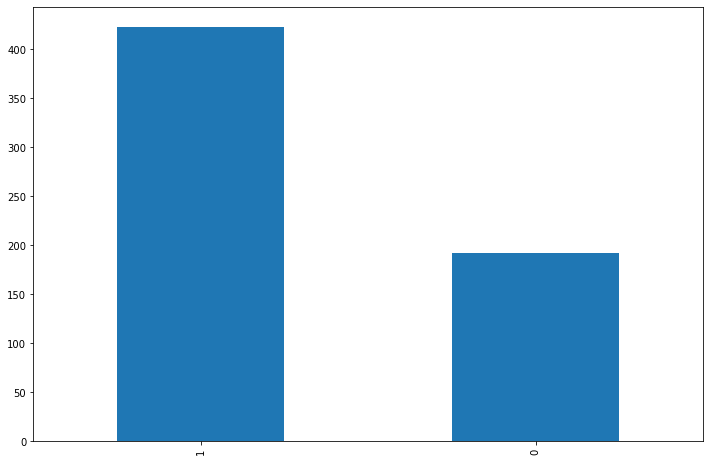

In [13]:
plt.figure(figsize=(12, 8))
ax = y.value_counts().plot(kind="bar")
# ax.set_title("Class Frequency")
# ax.set_xlabel("Approval Class")
# ax.set_ylabel("Frequency")
# ax.set_xticklabels(['yes','no'])

### Numerical Features

<AxesSubplot:>

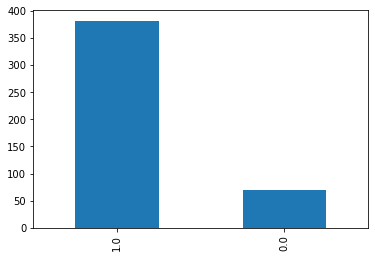

In [14]:
# Credit History distribution

X_train.Credit_History.value_counts().plot(kind='bar')

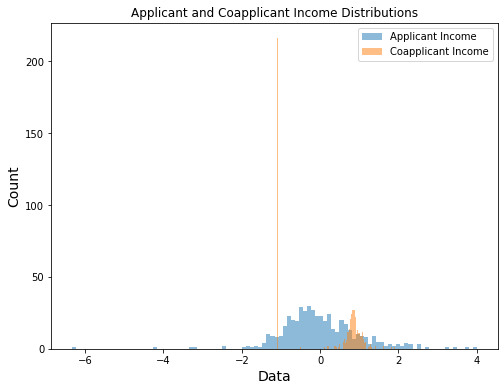

In [26]:
# Applicant Income, Coapplicant Income Distribution

plt.figure(figsize=(8,6))
plt.hist(X_train.ApplicantIncome, bins=100, alpha=0.5, label="Applicant Income")
plt.hist(X_train.CoapplicantIncome, bins=100, alpha=0.5, label="Coapplicant Income")

plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.title("Applicant and Coapplicant Income Distributions")
plt.legend(loc='upper right')

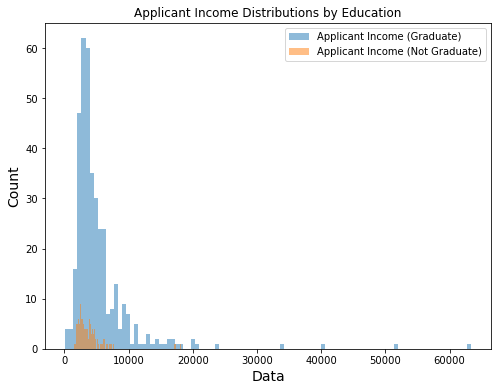

In [16]:
# Distribution of Income filtered by Education Status

plt.figure(figsize=(8,6))
plt.hist(X_train[X_train.Education == 'Graduate']['ApplicantIncome'], bins=100, alpha=0.5, label="Applicant Income (Graduate)")
plt.hist(X_train[X_train.Education == 'Not Graduate']['ApplicantIncome'], bins=100, alpha=0.5, label="Applicant Income (Not Graduate)")

plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.title("Applicant Income Distributions by Education")
plt.legend(loc='upper right')

Text(0.5, 1.0, 'Loan Amount Distribution')

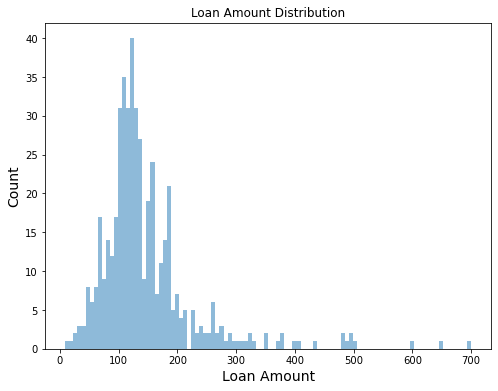

In [17]:
# Loan Amount Distribution

plt.figure(figsize=(8,6))
plt.hist(X_train.LoanAmount, bins=100, alpha=0.5, label="Loan Term")

plt.xlabel("Loan Amount", size=14)
plt.ylabel("Count", size=14)
plt.title("Loan Amount Distribution")

### Categorical Features

<AxesSubplot:>

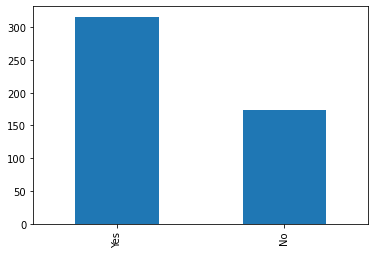

In [18]:
# Married distribution

X_train.Married.value_counts().plot(kind='bar')

<AxesSubplot:>

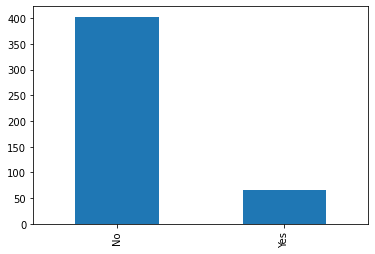

In [19]:
# Self employed distribution

X_train.Self_Employed.value_counts().plot(kind='bar')

<AxesSubplot:>

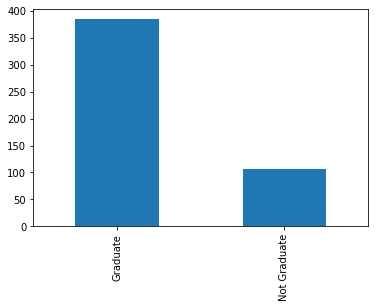

In [20]:
# Education distribution

X_train.Education.value_counts().plot(kind='bar')

<AxesSubplot:>

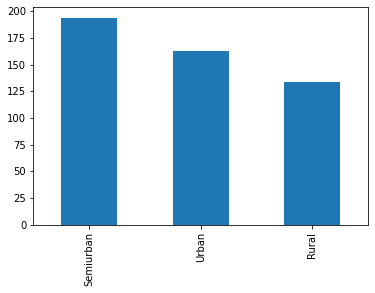

In [21]:
# Property area distribution

X_train.Property_Area.value_counts().plot(kind='bar')

<AxesSubplot:>

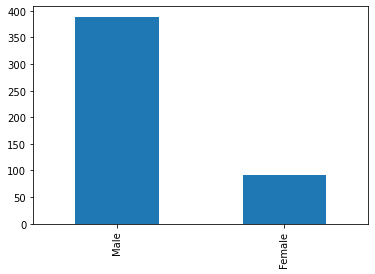

In [22]:
# Gender distribution

X_train.Gender.value_counts().plot(kind='bar')

## Pre-Modeling Data Steps

In [23]:
# Apply oversampling to training data to deal with class imbalance
# NOTE that this is not in pipeline because it is only done to training data

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=808)
X_train, y_train = ros.fit_resample(X_train, y_train)

<AxesSubplot:>

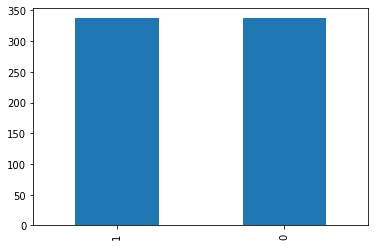

In [24]:
# verify resample

y_train.value_counts().plot(kind='bar')

## Construct Pipeline / Build Model

Flow:
* Split between numerical and categorical
* categorical
    * impute missing values (most_frequent)
    * onehot encoding
    * to_dense
    * PCA
* numerical
    * impute missing values (mean)
    * log_transform
    * standard scale
    * variance threshold
    * forward regression
* apply model

In [25]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,1
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1


In [26]:
# Get list of column names for categorical, numerical features


cat_feats = X_train.dtypes[X_train.dtypes == 'object'].index.tolist()
num_feats = X_train.dtypes[~X_train.dtypes.index.isin(cat_feats)].index.tolist()

In [27]:
# We will process Credit_History and Loan_Amount_Term seperately 

num_feats.pop()
num_feats.pop()

'Loan_Amount_Term'

In [28]:
num_feats

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

In [29]:
# fill missing values in Credit_History with 0
# assumption

def credit_nan(x):
    return x.replace(np.nan, 0)

credit_nan_transformer = FunctionTransformer(credit_nan)

In [30]:
# create to_dense function for use after onehot encoding

def to_dense(x):
    return x.toarray()

to_dense_transformer = FunctionTransformer(to_dense)

In [31]:
# import classifiers

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

In [32]:
# create numerical processing pipeline

num_processing = Pipeline([('num_impute', SimpleImputer()),
                           ('transform', PowerTransformer())
                          ])

In [33]:
# create categorical processing pipeline

cat_processing = Pipeline([('cat_impute', SimpleImputer(strategy='most_frequent')),
                           ('onehot', OneHotEncoder()),
                           ('dense', to_dense_transformer),
                           ('pca', PCA(n_components=3))
                          ])

In [34]:
# create Credit_History processing pipeline

credit_processing = Pipeline([('nan', credit_nan_transformer)])

In [35]:
# create Loan_Amount_Term pipeline

term_processing = Pipeline([('num_impute', SimpleImputer()),
                            ('scale', StandardScaler())
                           ])

In [36]:
# combine the four pipelines so they can be fitted to the final pipeline

processing = ColumnTransformer([('numerical', num_processing, num_feats),
                                ('categorical', cat_processing, cat_feats),
                                ('credit', credit_processing, ['Credit_History']),
                                ('term', term_processing, ['Loan_Amount_Term'])
                               ])

In [37]:
# assemble final pipeline

pipeline = Pipeline([('processing', processing),
                     ('clf', DecisionTreeClassifier())
                    ])

In [38]:
# fit pipeline to training data

pipeline.fit(X_train, y_train)

Pipeline(steps=[('processing',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('transform',
                                                                   PowerTransformer())]),
                                                  ['ApplicantIncome',
                                                   'CoapplicantIncome',
                                                   'LoanAmount']),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                             

In [39]:
# check score

pipeline.score(X_test,y_test)

0.6991869918699187

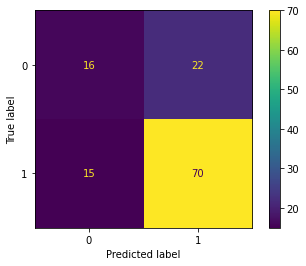

In [40]:
# check confusion matrix

from sklearn import metrics

y_pred = pipeline.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=pipeline.classes_)
disp.plot()

## Model Tuning

In [41]:
from sklearn.model_selection import GridSearchCV

In [42]:
# create parameter grid for tuning

param_grid = [{'processing__categorical__pca__n_components': [2,3,4],
              'clf': [RandomForestClassifier()],
              'clf__n_estimators': [250, 500, 1000],
              'clf__max_depth': [2,4,6]},
              
              {'processing__categorical__pca__n_components': [2,3,4],
              'clf': [GaussianNB()]},
              
              {'processing__categorical__pca__n_components': [2,3,4],
              'clf': [LinearSVC(dual=False)],
              'clf__C': [0.8, 1.0, 1.2],
              'clf__max_iter': [1000, 1500, 2000]},
              
              {'processing__categorical__pca__n_components': [2,3,4],
               'clf': [AdaBoostClassifier()],
               'clf__n_estimators': [1000, 1250, 1500],
               'clf__learning_rate': [1.25, 1.5, 1.75]},
              
              {'processing__categorical__pca__n_components': [2,3,4],
               'clf': [XGBClassifier(use_label_encoder=False, eval_metric='logloss')],
               'clf__n_estimators': [100,200,500],
               'clf__learning_rate': [0.6,0.8],
               'clf__max_depth': [4,5],
               'clf__colsample_bytree': [0.8,0.9]}
             ]
              

In [146]:
# create parameter grid for tuning

param_grid = [{'processing__categorical__pca__n_components': [3],
              'clf': [RandomForestClassifier()],
              'clf__n_estimators': [500],
              'clf__max_depth': [6]
              }]

In [147]:
# instantiate gridsearch

gridsearch = GridSearchCV(pipeline, param_grid=param_grid, n_jobs=-1)

In [148]:
# fit gridsearch to training data

gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('processing',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('transform',
                                                                                          PowerTransformer())]),
                                                                         ['ApplicantIncome',
                                                                          'CoapplicantIncome',
                                                                          'LoanAmount']),
                                                                        ('categorical',
                                                                  

In [149]:
# what did gridsearch find as best parameters?

print(gridsearch.best_params_)

{'clf': RandomForestClassifier(max_depth=6, n_estimators=500), 'clf__max_depth': 6, 'clf__n_estimators': 500, 'processing__categorical__pca__n_components': 3}


### Scoring the Model

In [150]:
print('Best score is: ', gridsearch.best_score_)

Best score is:  0.7730790491984522


In [151]:
# gridsearch final score

print('Test score is: ', gridsearch.score(X_test, y_test))

Test score is:  0.7642276422764228


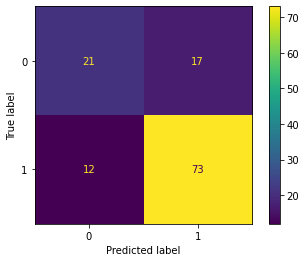

In [152]:
# check confusion matrix

from sklearn import metrics

y_pred = gridsearch.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred, labels=gridsearch.classes_)
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=gridsearch.classes_)
disp.plot()

## Pickle the Model

In [86]:
import pickle

In [87]:
with open('model/clf.p', 'wb') as fh:
   pickle.dump(gridsearch, fh)